<h1 align="center"> Tour of Machine Learning Algorithms for Binary Classification </h1>

<h1 align="center"> <a href="https://github.com/bagheri365/" target="_blank" rel="noopener noreferrer">Alireza Bagheri</a></h1>

<h1>Table of contents</h1>
<ul>   
    <li><a href="#Data">Data Example</a> </li>  
    <li><a href="#Data_prep"> Data Preparation </a></li>
    <li><a href="#lr"> Logistic Regression </a></li>
    <li><a href="#knn"> k-Nearest Neighbors (k-NN) </a></li> 
    <li><a href="#nb"> Naive Bayes </a></li>
    <li><a href="#svm_linear"> Linear SVM </a></li>
    <li><a href="#svm_rbf"> RBF SVM </a></li>
    <li><a href="#dtree"> Decision Tree </a></li>
    <li><a href="#rf"> Random Forest </a></li>
    <li><a href="#qda"> Quadratic Discriminant Analysis </a></li>
    <li><a href="#vc"> Voting Classifier </a></li>
    <li><a href="#mlp"> Multi-layer Perceptron </a></li>
</ul> 

## Data Example <a name="Data"></a>

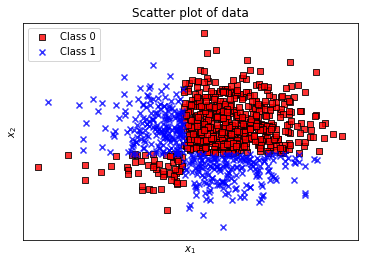

In [1]:
import numpy as np; np.random.seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.filterwarnings('ignore')

# XOR dataset
n_samples = 1000
mu, sigma = 2, 3
X = sigma * np.random.randn(n_samples, 2) + mu
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# Plot data
markers = ('s', 'x')
colors = ('red', 'blue')
target_names = ['Class 0', 'Class 1']
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x= X[y == cl, 0], y= X[y == cl, 1],
                alpha= 0.8, c= colors[idx],
                marker= markers[idx], label= target_names[cl], edgecolor= 'black') 
    
plt.xlabel('$x_1$'); plt.xticks([])
plt.ylabel('$x_2$'); plt.yticks([])
plt.title('Scatter plot of data')
plt.legend(loc="upper left")
plt.show()

## Data Preparation <a name="Data_prep"></a>

### Train/test split

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                     test_size= 0.25, 
                     stratify= y,
                     random_state= 123)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (750, 2)
X_test shape: (250, 2)


### Data standardization

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Helper function

In [4]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')

def run_classifier(clf, param_grid, title):
    # -----------------------------------------------------
    cv = StratifiedKFold(n_splits= 3, shuffle = True, random_state= 123)
    # Randomized grid search
    n_iter_search = 10
    gs = RandomizedSearchCV(clf, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            cv = cv, 
                            iid = False,
                            scoring= 'accuracy')
    # -----------------------------------------------------
    # Train model
    gs.fit(X_train, y_train)  
    print("The best parameters are %s" % (gs.best_params_)) 
    # Predict on test set
    y_pred = gs.best_estimator_.predict(X_test)
    # Get Probability estimates
    y_prob = gs.best_estimator_.predict_proba(X_test)[:, 1]
    # -----------------------------------------------------
    print('Accuracy score: %.2f%%' %(accuracy_score(y_test, y_pred)*100))  
    print('Precision score: %.2f%%' % (precision_score(y_test, y_pred)*100))
    print('Recall score: %.2f%%' % (recall_score(y_test, y_pred)*100))
    # ----------------------------------------------------- 
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(21, 7))
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
    ax1.set_title("Confusion Matrix")
    ax1.set_xlabel("Predicted class")
    ax1.set_ylabel("Actual class")
    fig.tight_layout()
    # -----------------------------------------------------
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax2.plot(fpr, tpr, lw = 2, label = 'AUC: {:.2f}'.format(auc(fpr, tpr)))
    ax2.plot([0, 1], [0, 1],
             linestyle = '--',
             color = (0.6, 0.6, 0.6),
             label = 'Random guessing')
    ax2.plot([0, 0, 1], [0, 1, 1],
             linestyle = ':',
             color = 'black', 
             label = 'Perfect performance')
    ax2.set_xlim([-0.05, 1.05])
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operator Characteristic (ROC) Curve')
    ax2.legend(loc = "lower right")
    fig.tight_layout()      
    # -----------------------------------------------------
    # Plot the decision boundary
    cmap = ListedColormap(colors[:len(np.unique(y_test))])
    x1_min, x1_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    x2_min, x2_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    resolution = 0.01 # step size in the mesh
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = gs.best_estimator_.predict(np.c_[xx1.ravel(), xx2.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    # plot class samples
    for idx, cl in enumerate(np.unique(y_test)):
        plt.scatter(x= X_test[y_test == cl, 0], 
                    y= X_test[y_test == cl, 1],
                    alpha= 0.8, 
                    c= colors[idx],
                    marker= markers[idx], 
                    label= target_names[cl], 
                    edgecolor= 'black')    
    ax3.set_title('Decision boundary of '+ str(title))
    ax3.set_xlabel("$x_1$")
    ax3.set_ylabel("$x_2$")
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.xticks([]); plt.yticks([])
    plt.legend(loc='lower left')
    plt.show()   

## Logistic Regression <a name="lr"></a>

The best parameters are {'solver': 'liblinear', 'penalty': 'l2'}
Accuracy score: 76.80%
Precision score: 72.50%
Recall score: 61.70%


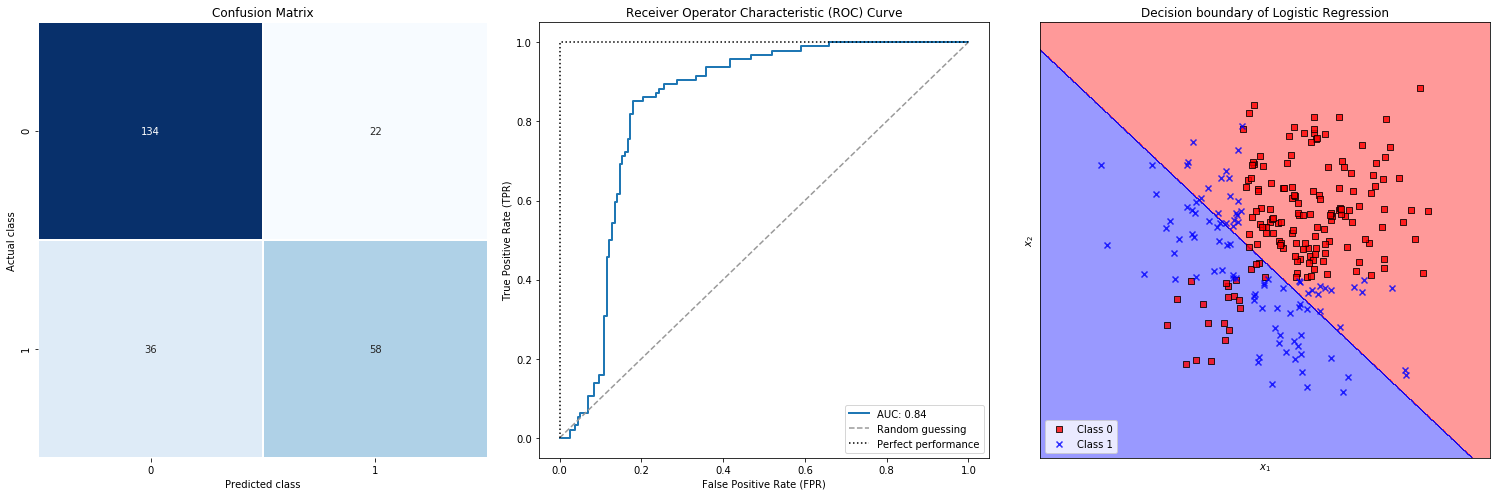

In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

param_grid = {'penalty': ['l2'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

run_classifier(lr, param_grid, 'Logistic Regression')

## k-Nearest Neighbors algorithm (k-NN) <a name="knn"></a>

The best parameters are {'weights': 'distance', 'n_neighbors': 7, 'leaf_size': 3, 'algorithm': 'auto'}
Accuracy score: 98.40%
Precision score: 97.87%
Recall score: 97.87%


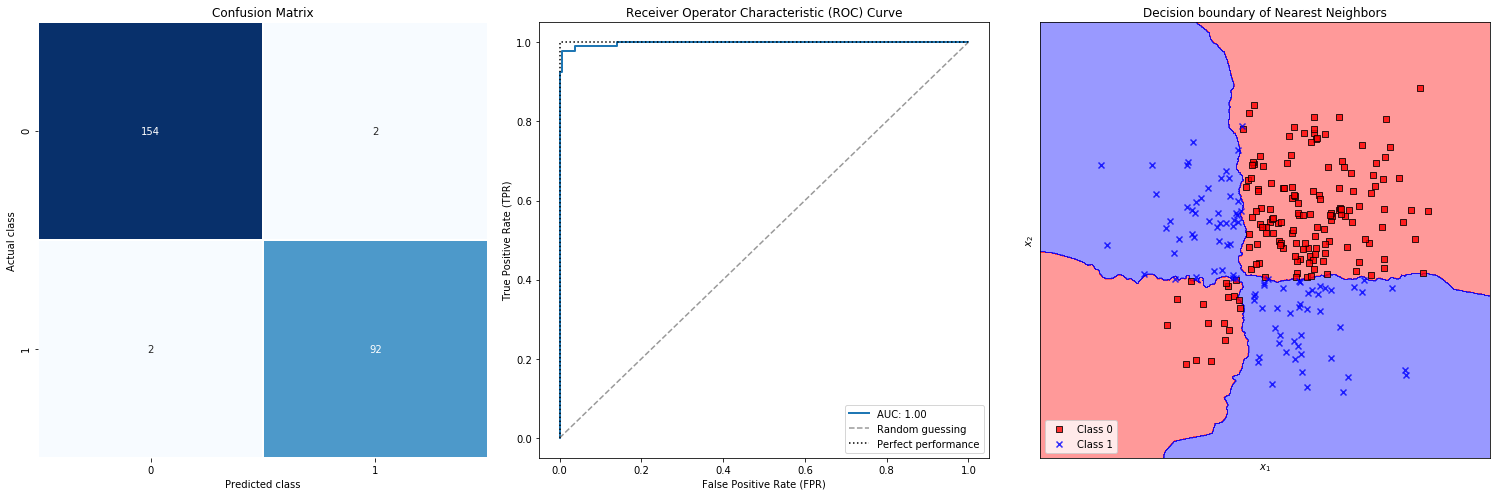

In [6]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(1,15), 
             'weights': ['uniform', 'distance'],
             'leaf_size':[1, 3, 5],
             'algorithm':['auto', 'kd_tree']}

run_classifier(knn, param_grid, 'Nearest Neighbors')

## Naive Bayes <a name="nb"></a>

The best parameters are {'priors': None}
Accuracy score: 76.40%
Precision score: 74.65%
Recall score: 56.38%


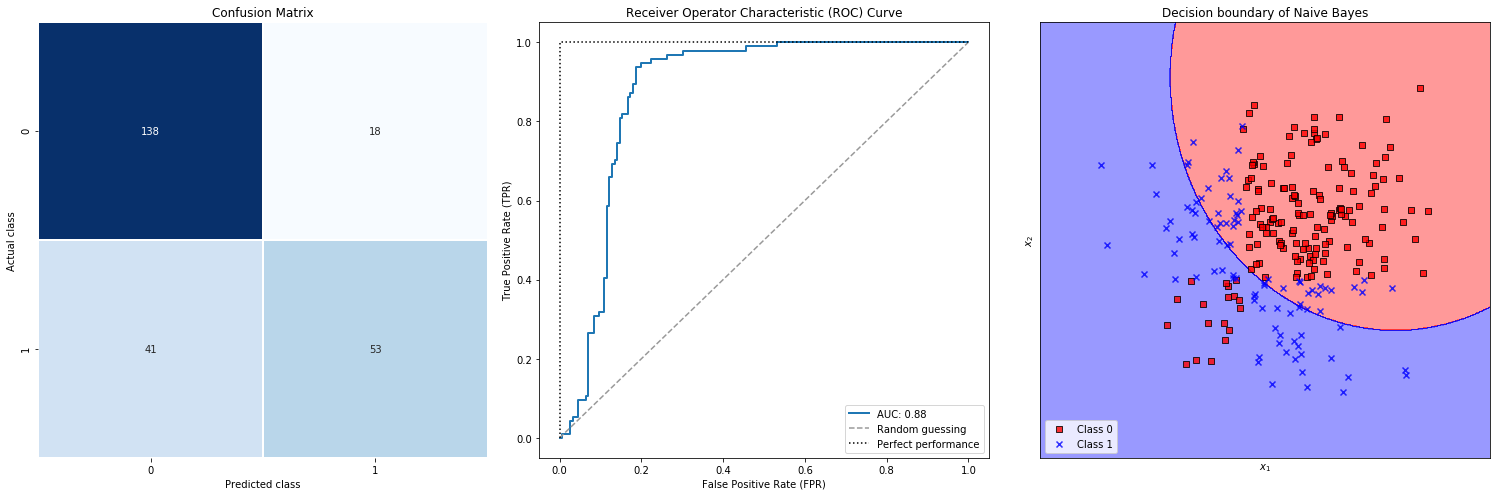

In [7]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

param_grid = {'priors': [None]}

run_classifier(nb, param_grid, 'Naive Bayes')

## Linear SVM <a name="svm_linear"></a>

The best parameters are {'gamma': 10.0, 'C': 0.1}
Accuracy score: 79.60%
Precision score: 73.12%
Recall score: 72.34%


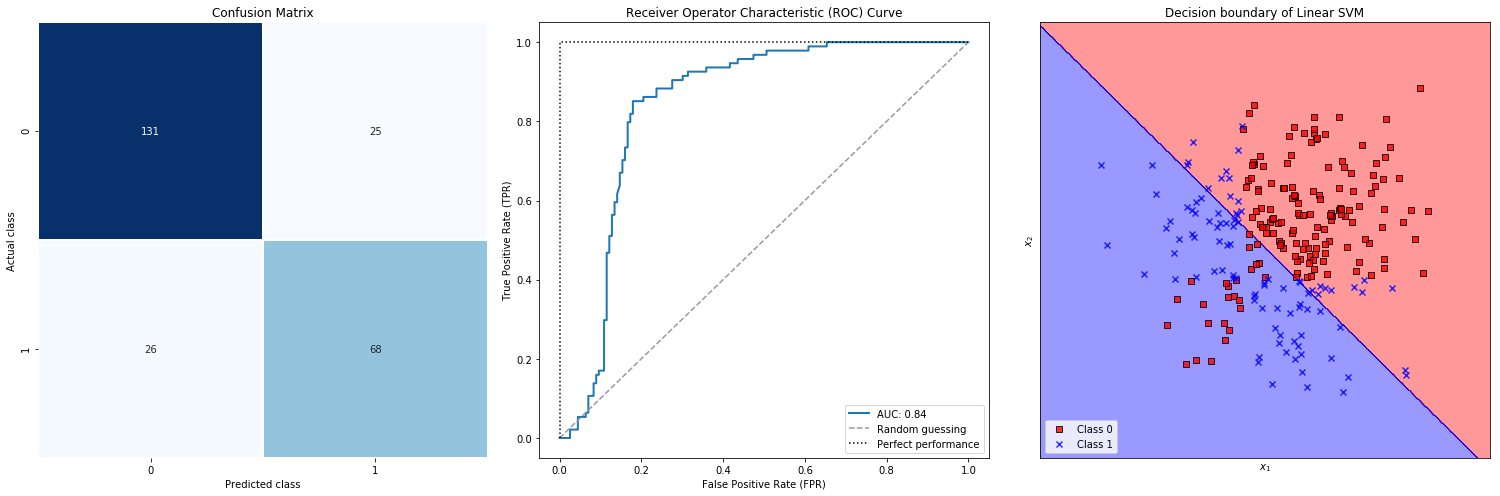

In [8]:
from sklearn.svm import SVC

svm_linear = SVC(kernel="linear", probability = True)

param_grid = {'gamma': np.logspace(-2, 2, 5),
              'C': np.logspace(-2, 2, 5)}

run_classifier(svm_linear, param_grid, 'Linear SVM')

## RBF SVM <a name="svm_rbf"></a>

The best parameters are {'gamma': 10.0, 'C': 10.0}
Accuracy score: 97.20%
Precision score: 100.00%
Recall score: 92.55%


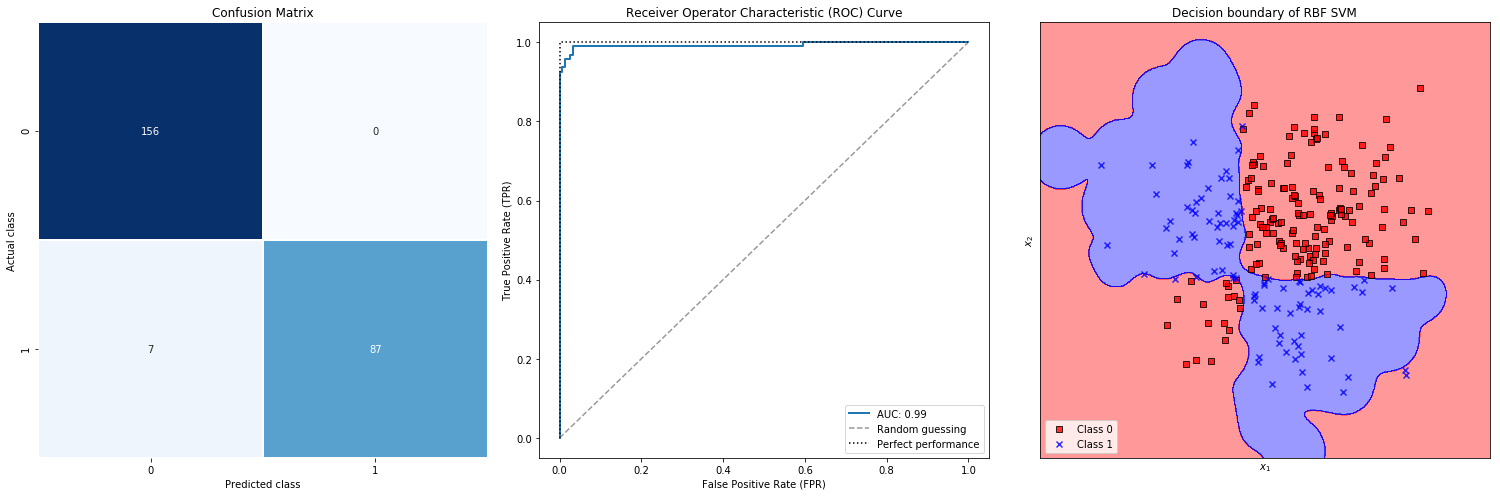

In [9]:
svm_rbf = SVC(kernel="rbf", probability=True)

param_grid = {'gamma': np.logspace(-2, 2, 5),
              'C': np.logspace(-2, 2, 5)}

run_classifier(svm_rbf, param_grid, "RBF SVM")

## Decision Tree <a name="dtree"></a>

The best parameters are {'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15, 'criterion': 'gini'}
Accuracy score: 97.20%
Precision score: 95.79%
Recall score: 96.81%


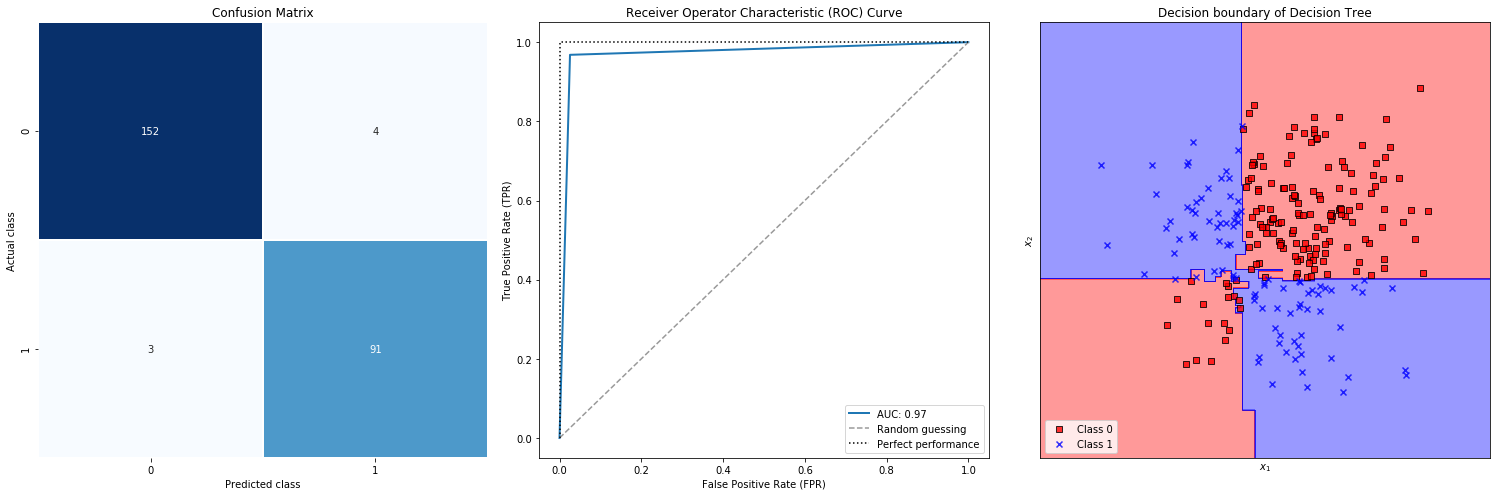

In [10]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': np.arange(1, 20, 2),
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 10],
              'max_features': ['auto', 'sqrt', 'log2', None]}

run_classifier(dtree, param_grid, "Decision Tree")

## Random Forest <a name="rf"></a>

The best parameters are {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'gini', 'bootstrap': True}
Accuracy score: 99.60%
Precision score: 100.00%
Recall score: 98.94%


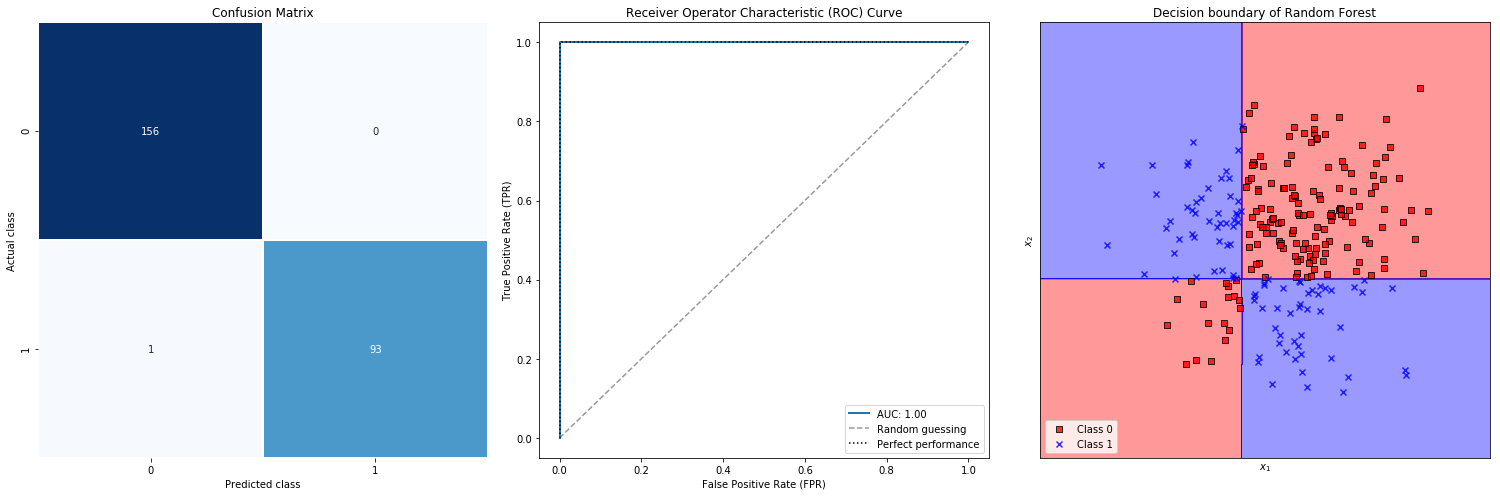

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_grid = {'n_estimators': [100, 200],
              'max_depth': [10, 20, 100, None],
              'max_features': ['auto', 'sqrt', None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 10],
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}

run_classifier(rf, param_grid, 'Random Forest')

## Quadratic Discriminant Analysis <a name="qda"></a>

The best parameters are {'reg_param': 0.0, 'priors': None}
Accuracy score: 86.80%
Precision score: 85.06%
Recall score: 78.72%


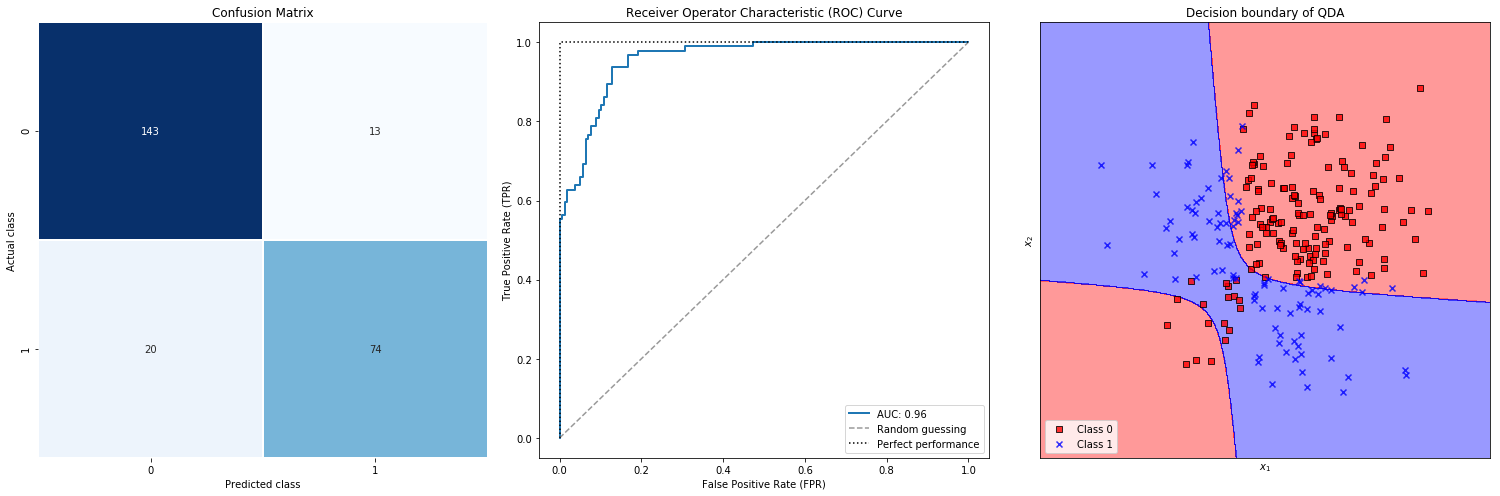

In [12]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()

param_grid = {'priors': [None], 
              'reg_param': np.arange(0., 1., 0.1)}

run_classifier(qda, param_grid, "QDA")

## Voting Classifier <a name="vc"></a>

The best parameters are {'weights': [1, 1, 1]}
Accuracy score: 98.40%
Precision score: 100.00%
Recall score: 95.74%


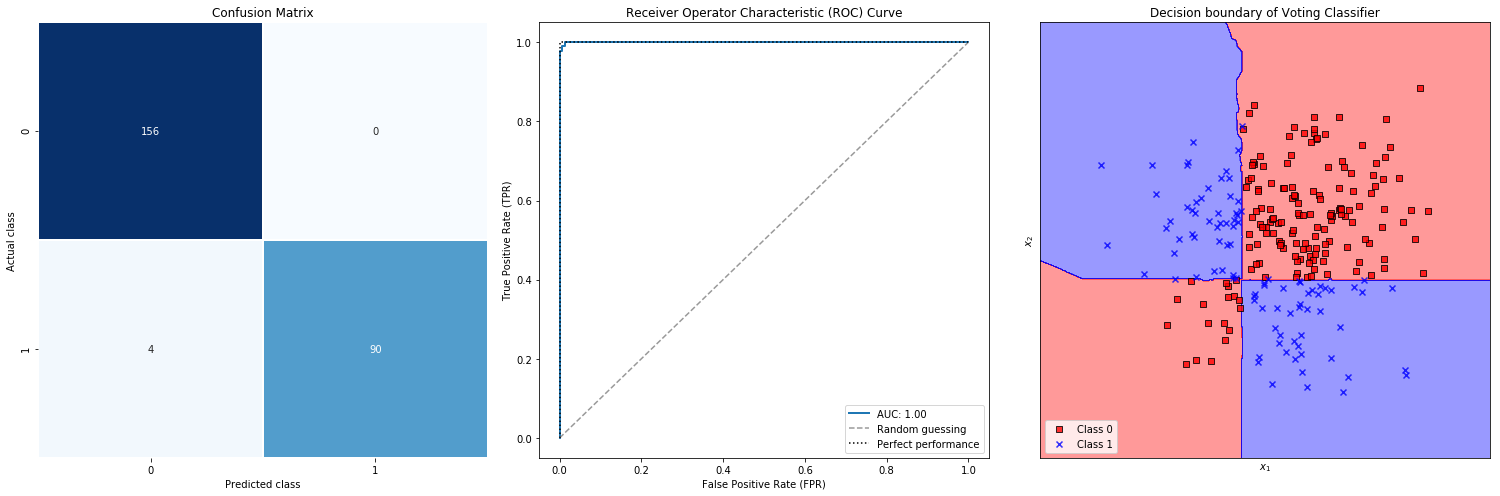

In [13]:
from sklearn.ensemble import VotingClassifier


vc = VotingClassifier(estimators=[('knn', knn), ('dt', dtree), ('svc', svm_rbf)],
                        voting='soft')

param_grid = {'weights': [[1, 1, 1], [2, 1, 2], [3, 1, 3]]}

run_classifier(vc, param_grid, "Voting Classifier")

## Multi-layer Perceptron <a name="mlp"></a>

The best parameters are {'solver': 'lbfgs', 'max_iter': 1000, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10, 10), 'alpha': 1e-05, 'activation': 'relu'}
Accuracy score: 99.20%
Precision score: 98.94%
Recall score: 98.94%


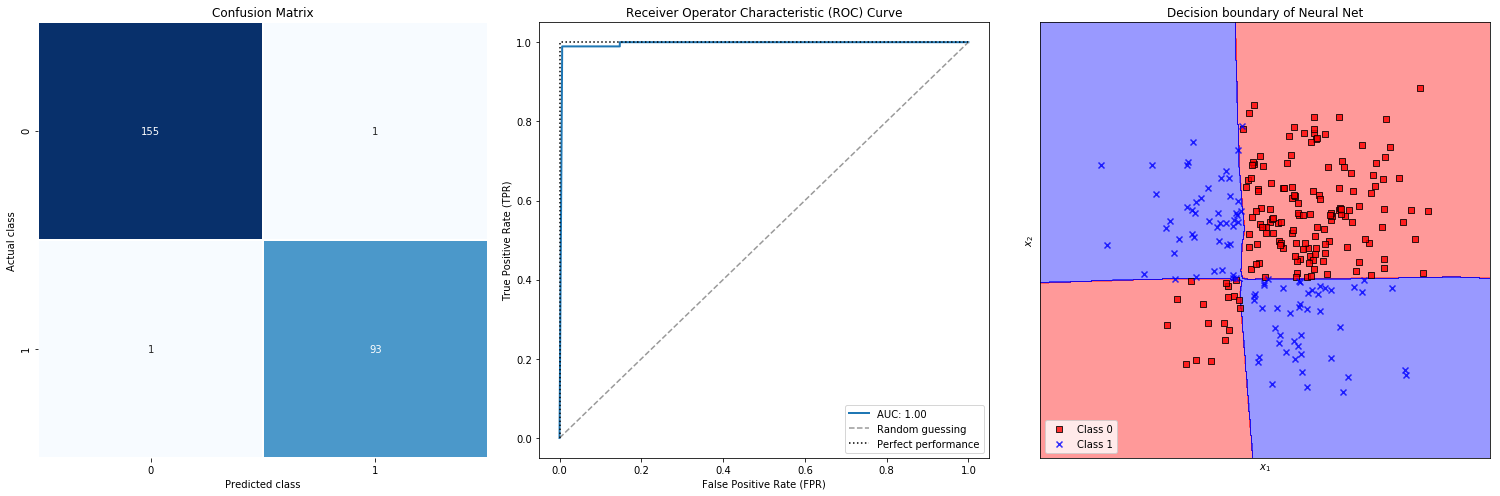

In [14]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

param_grid = {'hidden_layer_sizes': [(10,), (50,), (10, 10), (50, 50)],
             'activation': ['identity', 'logistic', 'tanh', 'relu'],
             'solver': ['lbfgs', 'sgd', 'adam'],
             'alpha': np.logspace(-5, 3, 5),
             'learning_rate': ['constant', 'invscaling','adaptive'],
             'max_iter': [100, 500, 1000]}

run_classifier(mlp, param_grid, 'Neural Net')